In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'titanic:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3136%2F26502%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240715%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240715T114814Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6ee24a451aed459a9e4719accf8f2b2ea2a997d3150e9bd02cae7d65af391486f0521dfa2bdd220828441e695efd6c6eb63862a26f88acff6b4c785b6baac32118135fc39b2f7dc8d9689ba76ed01bc774680cf2aa37f68d49fef263a6da6d9b302985a4599b64ee8a606fb978280d8ab9c7864c838aaf19a7ae01fa34d656eb39b33620f15fa77367ab28fd324500ce9a9d093bdd644d4294c5f85968dfb8c1fe9e44a0a837b44d0500be0e2f5ac2c73043c238243d87dd9e8bbbbd7f04486b373d18fc82f5de25015b2e73ac73e6c84bf77283ca62a3586ce35533865d56afd3198529e5d919e188f2675f5070c9b6bb98462184865202608d424618b3dc47'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 34877 bytes downloaded
Downloaded and uncompressed: titanic
Data source import complete.


# Importing Libraries

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/train.csv


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc


# 1.Data Preprocessing:

In [4]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [5]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [6]:
# Detail about the training data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train_data.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [8]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [10]:
train_data.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

Our DataSet Contains 8 columns

* Survived: Survival (0 = No, 1 = Yes)
* Pclass: Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
* Sex: Sex
* Age: Age in years
* SibSp: # of siblings / spouses aboard the Titanic
* Parch: # of parents / children aboard the Titanic
* Fare: Passenger fare
* Embarked: Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)
* Survived is the Target columns

### Data Exploration

In [11]:
categorical_columns = train_data.select_dtypes(include =["object","category"]).columns
categorical_columns


Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')

<Axes: >

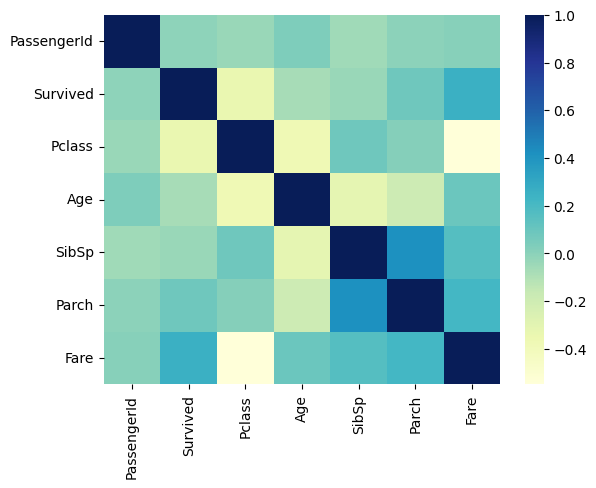

In [12]:
sns.heatmap(train_data.select_dtypes(include=['number']).corr(), cmap="YlGnBu")

<ipython-input-13-60251278eda3>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train_data, x='Sex', y='Survived', palette=palette)


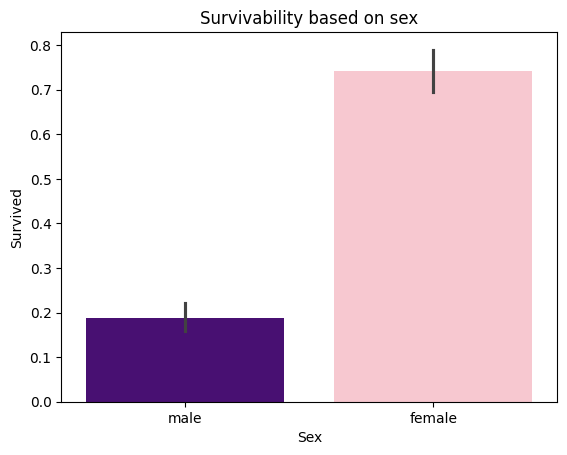

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a color palette
palette = {'male': 'indigo', 'female': 'pink'}

# Create the bar plot with the specified colors
sns.barplot(data=train_data, x='Sex', y='Survived', palette=palette)
plt.title("Survivability based on sex")
plt.xlabel('Sex')
plt.ylabel('Survived')
plt.show()


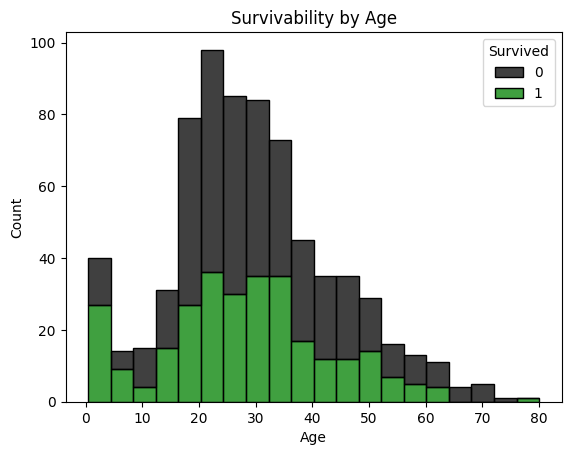

In [14]:
palette = {0: 'black', 1: 'green'}
sns.histplot(data=train_data, x='Age', hue='Survived', multiple='stack',palette=palette)
plt.title('Survivability by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

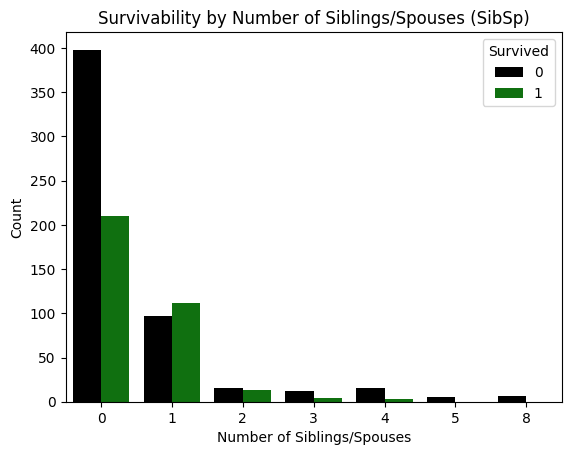

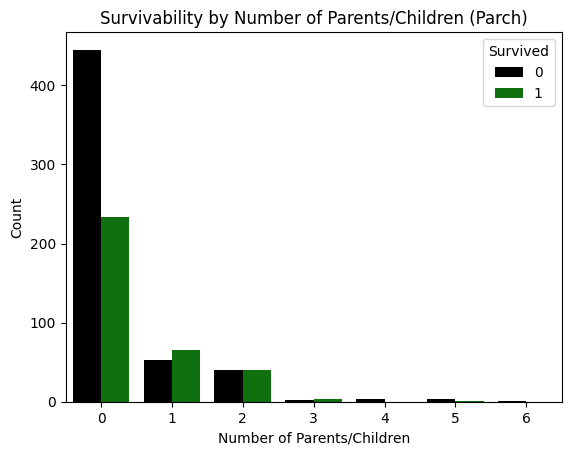

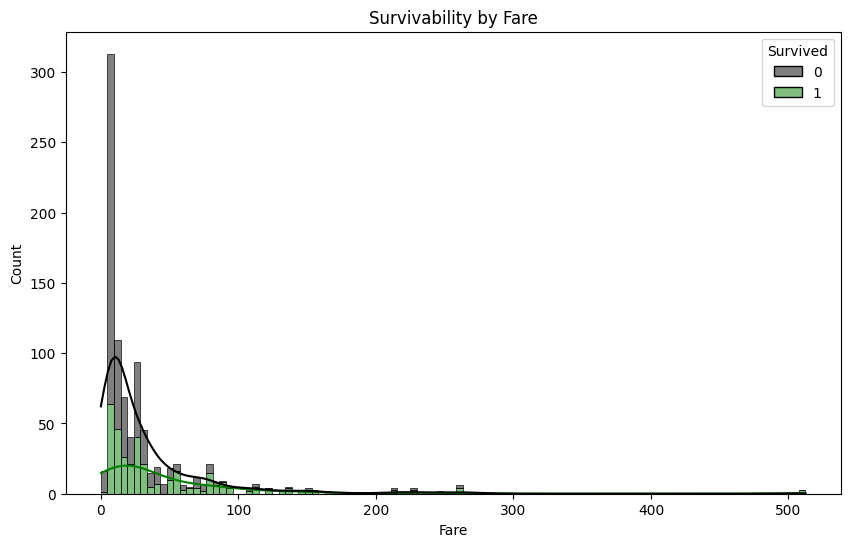

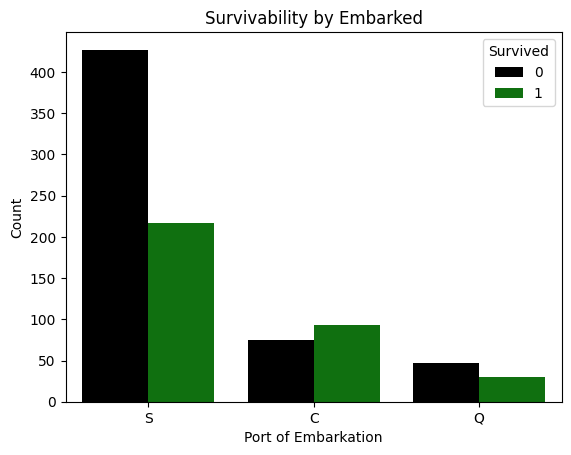

In [15]:
sns.countplot(x='SibSp', hue='Survived', data=train_data,palette=palette)
plt.title('Survivability by Number of Siblings/Spouses (SibSp)')
plt.xlabel('Number of Siblings/Spouses')
plt.ylabel('Count')
plt.legend(title='Survived', loc='upper right')
plt.show();

sns.countplot(x='Parch', hue='Survived', data=train_data,palette=palette)
plt.title('Survivability by Number of Parents/Children (Parch)')
plt.xlabel('Number of Parents/Children')
plt.ylabel('Count')
plt.legend(title='Survived', loc='upper right')
plt.show();

plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='Fare', hue='Survived', multiple='stack', kde=True,palette=palette)
plt.title('Survivability by Fare')
plt.xlabel('Fare')
plt.ylabel('Count')
plt.show();

# Plot the survivability by Embarked
sns.countplot(x='Embarked', hue='Survived', data=train_data,palette=palette)
plt.title('Survivability by Embarked')
plt.xlabel('Port of Embarkation')
plt.ylabel('Count')
plt.legend(title='Survived', loc='upper right')
plt.show();

children have high survivability

**From these graphs we can gather that:**

* Most of the passengers on the Titanic died.
*Women and children had better chance tO survIVE than men  while the majority of the men died.
*The higher the passenger class, the better chance of survival.
*Those who embarked from C had a slightly higher chance of survival than those who embarked from other places.
*Passengers who paid a higher fare price had, in general, a higher chance of survival than those who paid less for their fare.

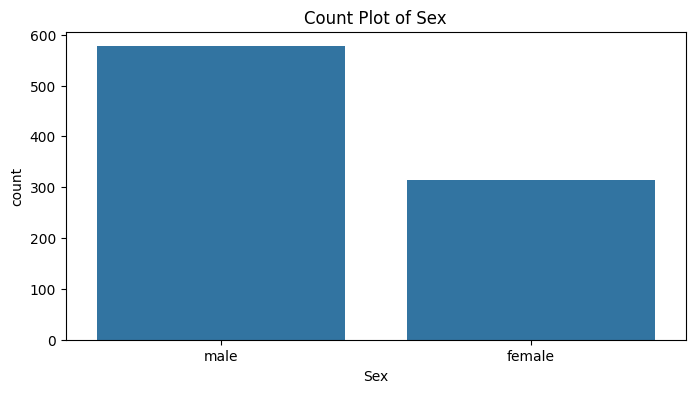

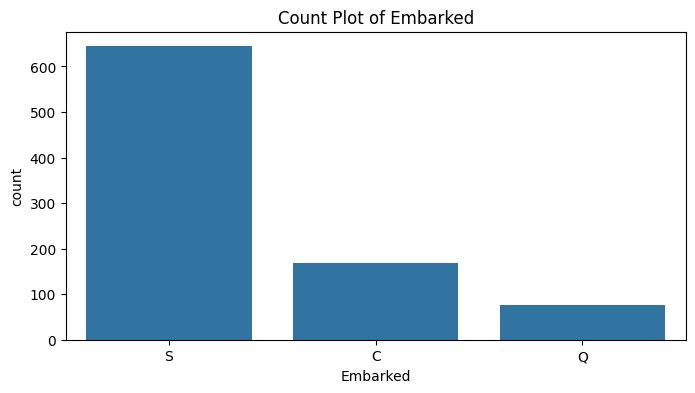

In [16]:
# Count plots for categorical features
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_data is your DataFrame and you want to plot count plots for these features
features = ['Sex', 'Embarked']

# Plot count plots for each feature
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=train_data[feature])
    plt.title(f'Count Plot of {feature}')
    plt.show()


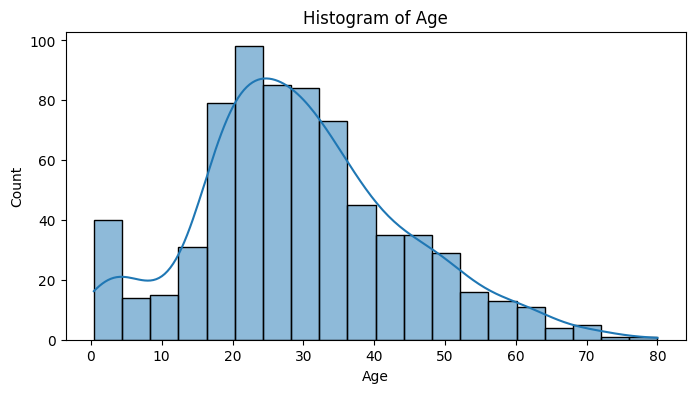

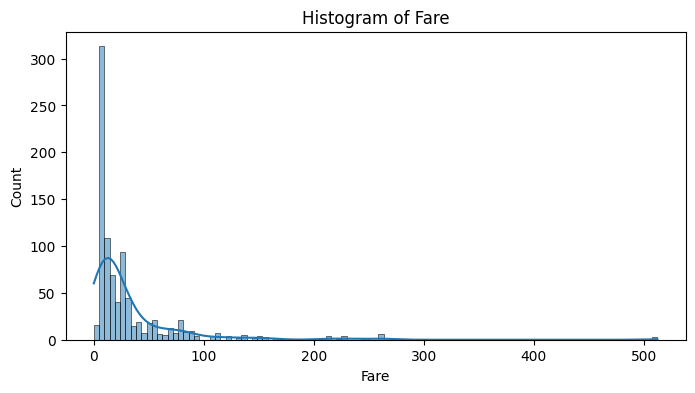

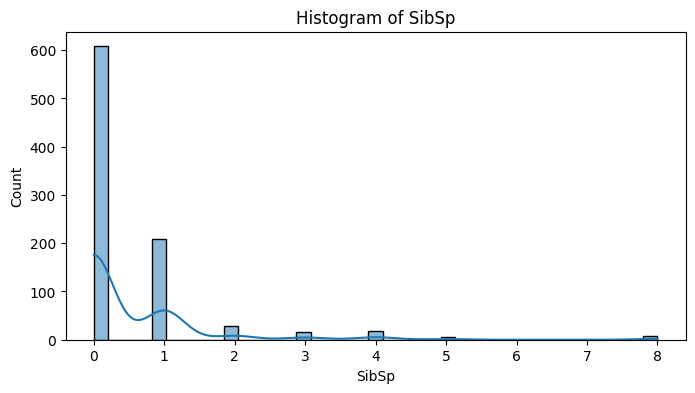

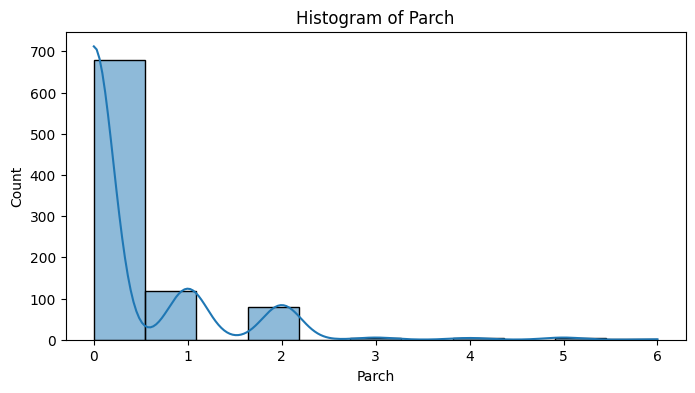

In [17]:
# Histogram plot for numerical features
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch']
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(train_data[feature].dropna(), kde=True)
    plt.title(f'Histogram of {feature}')
    plt.show()

#### Create boxplots to identify potential outliers

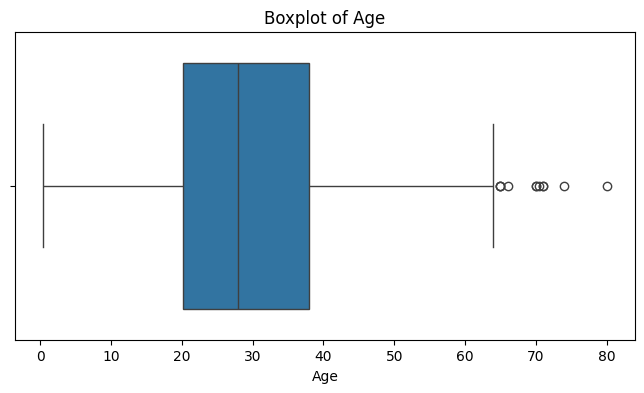

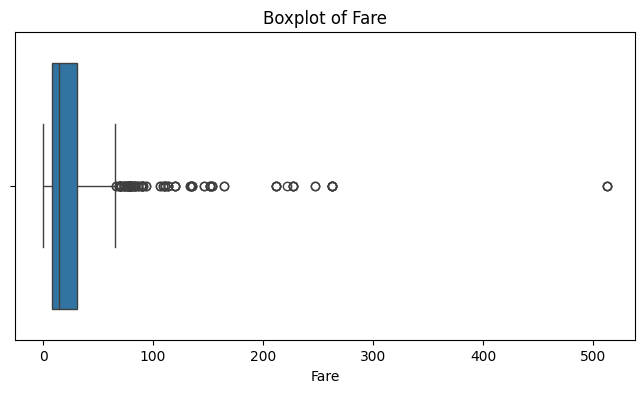

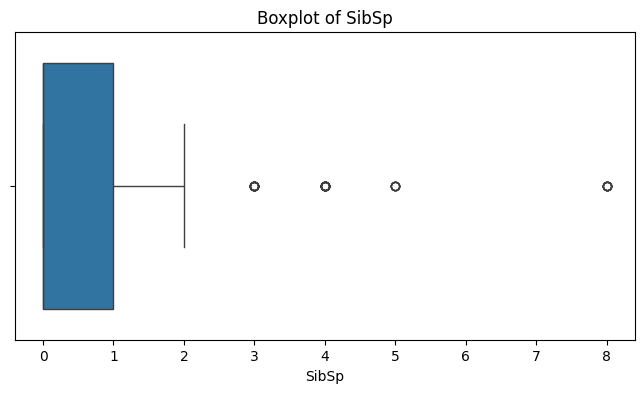

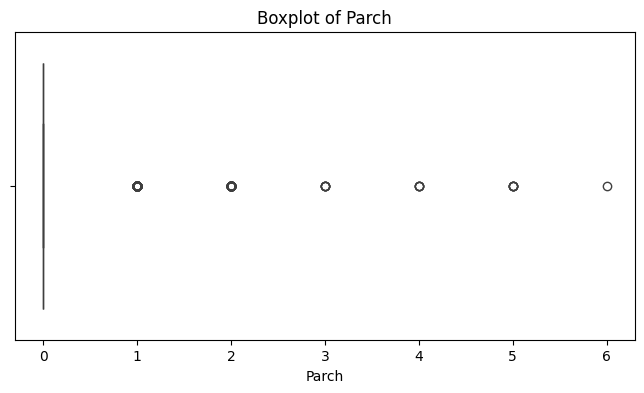

In [18]:
# BoxPlots to identify potential outliers
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=train_data[feature].dropna())
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)
    plt.show()

# Data Processing
Data processing is a crucial step in preparing the dataset for modeling. It involves handling missing values, converting categorical variables into numerical format, and performing any necessary scaling of features. Proper data processing ensures that the machine learning algorithms can effectively learn from the data.

## Handling missing values

### Feature Engineering
Feature engineering is the process of creating new features or modifying existing ones to improve the performance of machine learning models. This can include combining features, extracting new features from existing ones, or transforming features into more useful representations.

We will perform very basic feature engineering:

Creating new features based on existing ones.
Combining features.
Transforming features

Create new features that might improve the model's performance.**

In [19]:
import pandas as pd
import numpy as np
# Title Extraction
train_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
train_data['Title'] = train_data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                                   'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train_data['Title'] = train_data['Title'].replace('Mlle', 'Miss')
train_data['Title'] = train_data['Title'].replace('Ms', 'Miss')
train_data['Title'] = train_data['Title'].replace('Mme', 'Mrs')

# Family Size
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1

# Is Alone
train_data['IsAlone'] = 0
train_data.loc[train_data['FamilySize'] == 1, 'IsAlone'] = 1

# Age Binning
train_data['AgeBin'] = pd.cut(train_data['Age'], bins=[0, 12, 20, 40, 60, 80], labels=['Child', 'Teen', 'Adult', 'Middle-aged', 'Senior'])

# Fare Binning
train_data['FareBin'] = pd.qcut(train_data['Fare'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

# Cabin Letter
train_data['CabinLetter'] = train_data['Cabin'].str[0]
train_data['CabinLetter'] = train_data['CabinLetter'].fillna('Unknown')

# Ticket Prefix
train_data['TicketPrefix'] = train_data['Ticket'].apply(lambda x: x.split()[0] if len(x.split()) > 1 else 'NoPrefix')

# Encode Embarked
train_data['Embarked'] = train_data['Embarked'].fillna('S')
train_data['Embarked'] = train_data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

# Encode Sex
train_data['Sex'] = train_data['Sex'].map({'male': 0, 'female': 1}).astype(int)

# Fill missing values for Age and Fare
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
train_data['Fare'].fillna(train_data['Fare'].median(), inplace=True)

# Drop unnecessary columns
train_data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Select categorical features to encode
categorical_features = ['Title', 'AgeBin', 'FareBin', 'CabinLetter', 'TicketPrefix']

# Apply OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_features = pd.DataFrame(encoder.fit_transform(train_data[categorical_features]),
                                columns=encoder.get_feature_names_out(categorical_features))

# Concatenate the encoded features with the original dataframe
train_data = pd.concat([train_data, encoded_features], axis=1)

# Drop original categorical columns
train_data.drop(categorical_features, axis=1, inplace=True)

# Display the first few rows of the modified dataset
print(train_data.head())


   PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  \
0            1         0       3    0  22.0      1      0   7.2500         0   
1            2         1       1    1  38.0      1      0  71.2833         1   
2            3         1       3    1  26.0      0      0   7.9250         0   
3            4         1       1    1  35.0      1      0  53.1000         0   
4            5         0       3    0  35.0      0      0   8.0500         0   

   FamilySize  ...  TicketPrefix_SOTON/O.Q.  TicketPrefix_SOTON/O2  \
0           2  ...                      0.0                    0.0   
1           2  ...                      0.0                    0.0   
2           1  ...                      0.0                    0.0   
3           2  ...                      0.0                    0.0   
4           1  ...                      0.0                    0.0   

   TicketPrefix_SOTON/OQ  TicketPrefix_STON/O  TicketPrefix_STON/O2.  \
0                    0.0  

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [20]:
train_data.isnull().sum()

PassengerId            0
Survived               0
Pclass                 0
Sex                    0
Age                    0
                      ..
TicketPrefix_SW/PP     0
TicketPrefix_W./C.     0
TicketPrefix_W.E.P.    0
TicketPrefix_W/C       0
TicketPrefix_WE/P      0
Length: 73, dtype: int64

### Scale,apply PCA and data Spliting
Splitting the data into training and validation sets is essential for evaluating the performance of our machine learning model. The training set is used to train the model, while the validation set is used to assess its performance. This helps in ensuring that the model generalizes well to unseen data.


train_test_split(): Splits arrays or matrices into random train and validation subsets

In [21]:
from sklearn.decomposition import PCA
# Define the features (X) and the target (y)
X = train_data.drop('Survived', axis=1)
y = train_data['Survived']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca = pca.fit_transform(X_scaled)

In [22]:
# Split the training data into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size=0.2, random_state=42)  # Use train_test_split to split the data

# Display the shapes of the resulting datasets
print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Validation set: {X_val.shape}, {y_val.shape}')


Training set: (712, 57), (712,)
Validation set: (179, 57), (179,)


# Model Training


1.   Logistic Regression
2.   SVM
3. Random forest
3.   Naives Bayes





**Logistic Regression**

Validation Set Evaluation:
Accuracy: 0.7821229050279329
Precision: 0.7397260273972602
Recall: 0.7297297297297297
F1 Score: 0.7346938775510203

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.82      0.82       105
           1       0.74      0.73      0.73        74

    accuracy                           0.78       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



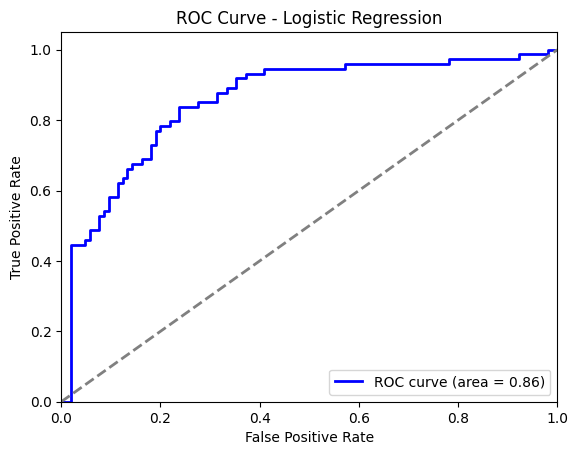

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Train a Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = log_reg.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

report = classification_report(y_val, y_val_pred)

print(f'Validation Set Evaluation:\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n')
print('Classification Report:\n', report)

# ROC Curve
y_val_prob = log_reg.predict_proba(X_val)[:,1]
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()


**Hyperparameters tunning with Logistic Regression**


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
240 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Sol

Best Parameters: {'C': 0.23357214690901212, 'penalty': 'l1', 'solver': 'saga'}
Logistic Regression Model Accuracy: 0.8045


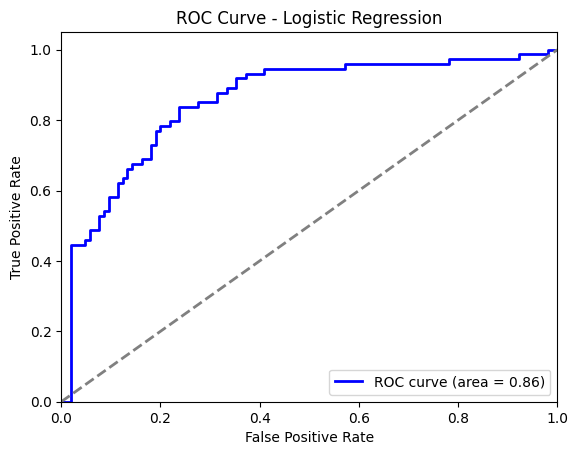

In [24]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.logspace(-4, 4, 20),
    'solver': ['lbfgs', 'liblinear', 'saga']
}

# Create the GridSearchCV object
grid_search_lr = GridSearchCV(estimator=LogisticRegression(max_iter=100),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=3,  # 5-fold cross-validation
                           verbose=0,  # Set to 0 for no verbosity
                           n_jobs=-1)  # Use all available cores

# Fit the grid search to the data
grid_search_lr.fit(X_train, y_train)

# Get the best parameters
best_params_lr = grid_search_lr.best_params_
print(f'Best Parameters: {best_params_lr}')

# Train the model with the best parameters
best_model_lr = grid_search_lr.best_estimator_

# Evaluate the model
y_pred_lr = best_model_lr.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_lr)
print(f'Logistic Regression Model Accuracy: {accuracy:.4f}')
# ROC Curve
y_val_prob = log_reg.predict_proba(X_val)[:,1]
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()


**Support Vector Machine**

SVM Accuracy: 0.8045
[[89 16]
 [19 55]]
Other Metrics:
Precision: 0.7746478873239436
Recall: 0.7432432432432432
F1 Score: 0.7586206896551724

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84       105
           1       0.77      0.74      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179



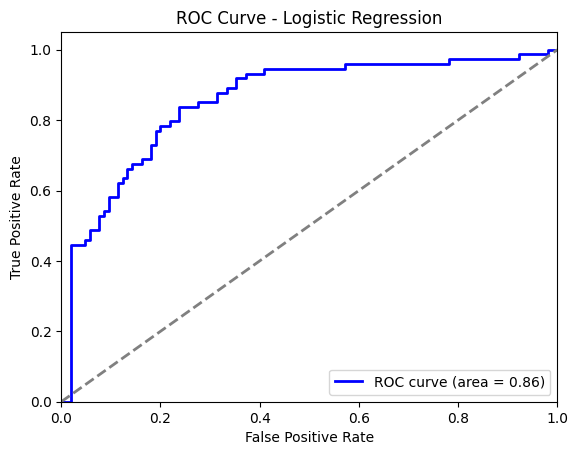

In [25]:
from sklearn.metrics import confusion_matrix,accuracy_score
# Support Vector Machine
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_val)
cm_svm= confusion_matrix (y_val,svm_pred)
precision = precision_score(y_val, svm_pred)
recall = recall_score(y_val, svm_pred)
f1 = f1_score(y_val, svm_pred)
report = classification_report(y_val, svm_pred)

print(f'SVM Accuracy: {accuracy_score(y_val, svm_pred):.4f}')
print(cm_svm)

print(f'Other Metrics:\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n')
print('Classification Report:\n', report)
# ROC Curve
y_val_prob = log_reg.predict_proba(X_val)[:,1]
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()



**HYPERPARAMETERTUNING With SVM**

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVM Model Accuracy: 0.8268
[[89 16]
 [19 55]]
Other Metrics:
Precision: 0.8208955223880597
Recall: 0.7432432432432432
F1 Score: 0.7801418439716312

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86       105
           1       0.82      0.74      0.78        74

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



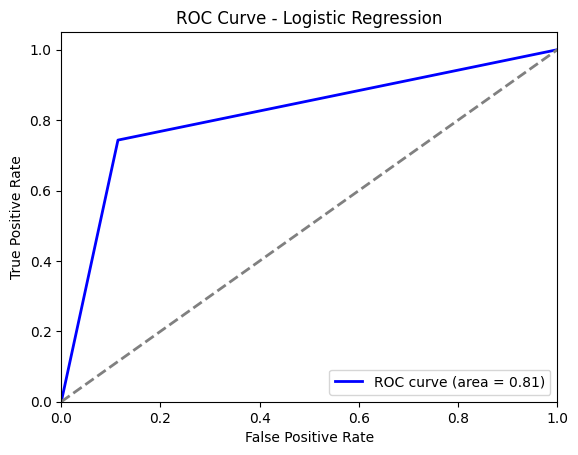

In [26]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01,],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

# Create the GridSearchCV object
grid_search_svm = GridSearchCV(estimator=SVC(),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=3,  # 3-fold cross-validation
                           verbose=1,  # Set to 0 for no verbosity
                           n_jobs=-1)  # Use all available cores

# Fit the grid search to the data
grid_search_svm.fit(X_train, y_train)

# Get the best parameters
best_params_svm = grid_search_svm.best_params_
print(f'Best Parameters: {best_params_svm}')

# Train the model with the best parameters
best_model_svm = grid_search_svm.best_estimator_

# Evaluate the model
y_pred_svm = best_model_svm.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_svm)

precision = precision_score(y_val, y_pred_svm)
recall = recall_score(y_val, y_pred_svm)
f1 = f1_score(y_val, y_pred_svm)
report = classification_report(y_val, y_pred_svm)


print(f'SVM Model Accuracy: {accuracy:.4f}')
print(cm_svm)
print(f'Other Metrics:\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n')
print('Classification Report:\n', report)

# ROC Curve
y_val_prob = log_reg.predict_proba(X_val)[:,1]
fpr, tpr, _ = roc_curve(y_val, y_pred_svm)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()



## Using Random Forests Model

Random Forest Accuracy: 0.8156
Other Metrics:
Precision: 0.7971014492753623
Recall: 0.7432432432432432
F1 Score: 0.7692307692307693
Confusion matrix:[[91 14]
 [19 55]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.81      0.82      0.81       179



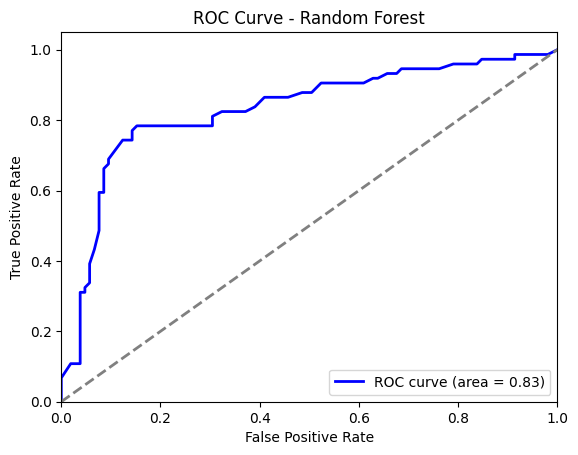

In [27]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)

cm_rf = confusion_matrix(y_val, rf_pred)
precision = precision_score(y_val, rf_pred)
recall = recall_score(y_val, rf_pred)
f1 = f1_score(y_val, rf_pred)
report = classification_report(y_val, rf_pred)

print(f'Random Forest Accuracy: {accuracy_score(y_val, rf_pred):.4f}')
print(f'Other Metrics:\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\nConfusion matrix:{cm_rf}\n')
print('Classification Report:\n', report)

# ROC Curve
y_val_prob = rf_model.predict_proba(X_val)[:,1]
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

HYPERPARAMETERTUNING With **RANDOM FOREST**

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 300}
Random Forest Accuracy: 0.8156
Other Metrics:
Precision: 0.8059701492537313
Recall: 0.7297297297297297
F1 Score: 0.7659574468085106
Confusion matrix:[[92 13]
 [20 54]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       105
           1       0.81      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



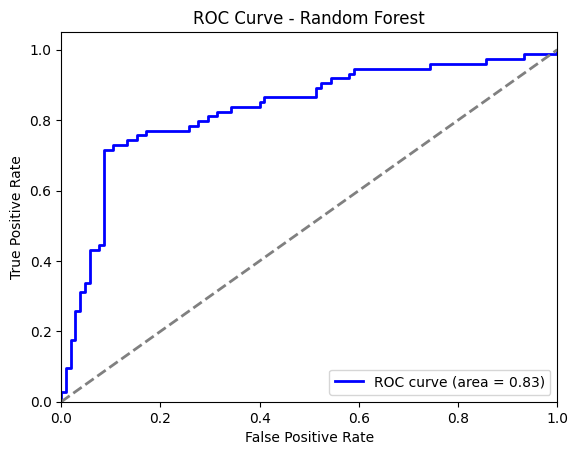

In [28]:
rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5]
}


# Perform GridSearchCV for each model
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(),
                           param_grid=rf_param_grid,
                           scoring='accuracy',
                           cv=3,
                           verbose=2,
                           n_jobs=-1)

# Fit the grid search to the data
grid_search_rf.fit(X_train, y_train)

# Get the best parameters
best_params_rf = grid_search_rf.best_params_
print(f'Best Parameters for RandomForestClassifier: {best_params_rf}')

# Train the model with the best parameters
best_model_rf = grid_search_rf.best_estimator_

# Evaluate the model
y_pred_rf = best_model_rf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_rf)

cm_rf = confusion_matrix(y_val, y_pred_rf)
precision = precision_score(y_val, y_pred_rf)
recall = recall_score(y_val, y_pred_rf)
f1 = f1_score(y_val, y_pred_rf)
report = classification_report(y_val, y_pred_rf)

print(f'Random Forest Accuracy: {accuracy_score(y_val, rf_pred):.4f}')
print(f'Other Metrics:\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\nConfusion matrix:{cm_rf}\n')
print('Classification Report:\n', report)


# ROC Curve
y_val_prob = best_model_rf.predict_proba(X_val)[:,1]
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

## NAIVE BAYES

Evaluation:
Accuracy: 0.4748603351955307
Precision: 0.43902439024390244
Recall: 0.972972972972973
F1 Score: 0.6050420168067226

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.12      0.22       105
           1       0.44      0.97      0.61        74

    accuracy                           0.47       179
   macro avg       0.65      0.55      0.41       179
weighted avg       0.69      0.47      0.38       179



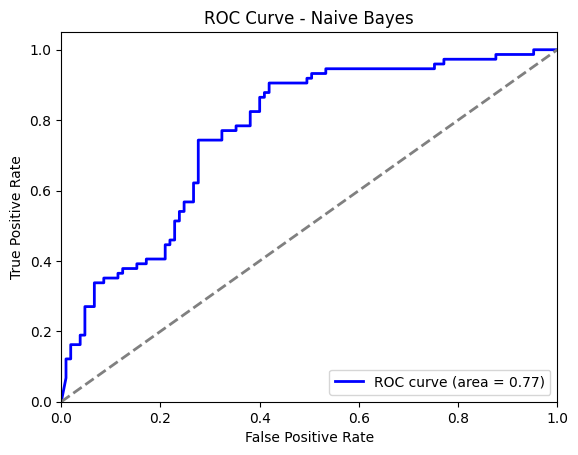

In [29]:
from sklearn.naive_bayes import GaussianNB
# Train a Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = nb_model.predict(X_val)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred)

print(f'Evaluation:\nAccuracy: {val_accuracy}\nPrecision: {val_precision}\nRecall: {val_recall}\nF1 Score: {val_f1}\n')
print('Classification Report:\n', val_report)

# ROC Curve
y_val_prob = nb_model.predict_proba(X_val)[:,1]
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes')
plt.legend(loc="lower right")
plt.show()

Best Parameters: {'var_smoothing': 1.0}
Validation Set Evaluation:
Accuracy: 0.7318435754189944
Precision: 0.6203703703703703
Recall: 0.9054054054054054
F1 Score: 0.7362637362637362

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.61      0.73       105
           1       0.62      0.91      0.74        74

    accuracy                           0.73       179
   macro avg       0.76      0.76      0.73       179
weighted avg       0.79      0.73      0.73       179



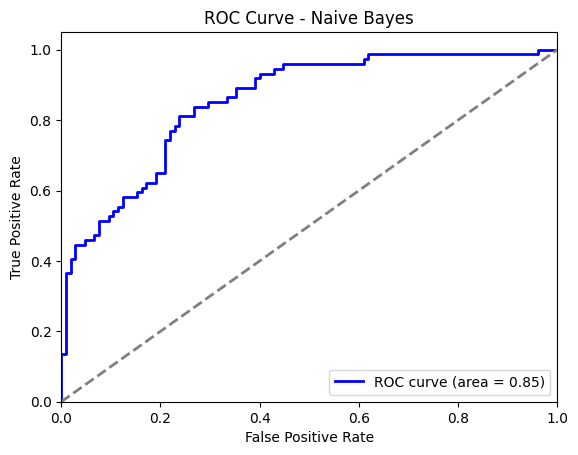

In [30]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'var_smoothing': np.logspace(-9, 0, 10)
}


# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters from grid search
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

# Train the Naive Bayes model with the best parameters
best_nb_model = GaussianNB(var_smoothing=best_params['var_smoothing'])
best_nb_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = best_nb_model.predict(X_val)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred)

print(f'Validation Set Evaluation:\nAccuracy: {val_accuracy}\nPrecision: {val_precision}\nRecall: {val_recall}\nF1 Score: {val_f1}\n')
print('Classification Report:\n', val_report)

# ROC Curve
y_val_prob = best_nb_model.predict_proba(X_val)[:,1]
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes')
plt.legend(loc="lower right")
plt.show()
